So i took the popular xgb sciprt (which we all have variants of) and looked at the OOB predictions and where the model is most inaccurate, based on a conversation in the forums about low prices causing 'large' errors

Original XGB and parms here:
https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317

Comment on errors here:
https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/32608

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
#now = datetime.datetime.now()

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
macro = pd.read_csv('./data/macro.csv')
id_test = test.id
train.sample(3)

/home/robert/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
27144,27147,2014-12-25,47,31.0,11.0,14.0,5.0,1972.0,2.0,9.0,...,8,3,0,6,16,0,2,35,5,6200000
4421,4424,2012-10-26,79,75.0,13.0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,5,1,6256800
16740,16743,2014-03-31,112,67.0,9.0,16.0,1.0,1996.0,5.0,10.0,...,9,1,1,6,6,0,1,33,4,16800000


In [2]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  

Ok so less do a CV OOB prediction and look at what happens.

In [3]:
from sklearn.cross_validation import cross_val_predict as cvp
xgb_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, silent=True, objective='reg:linear', nthread=-1, subsample=1, colsample_bytree=0.7, colsample_bylevel=0.7)


In [4]:
y_pred = cvp(xgb_model, x_train,y_train, cv=5, n_jobs = 1,verbose=10,fit_params={'eval_metric':'rmse'})

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


Ok, now I will calculate the RMSLE and RMSE errors using the target and predictions (Make sure you understand the use of abs() in place of taking the SQRT of the Square of the difference).

In [9]:
error=pd.DataFrame({'target':y_train,'pred':y_pred})
error['rmsle']=abs(np.log(error['target']+1)-np.log(error['pred']+1))
error['rmse']=abs(error['target']-error['pred'])

Ok so lets look at how the target and prediction match up.

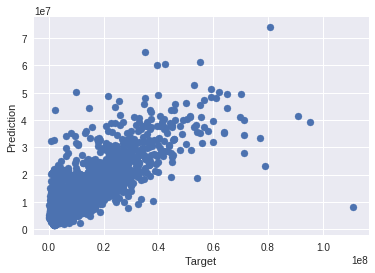

In [14]:
fig, ax = plt.subplots()
ax.scatter(error['target'],error['pred'])
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
plt.show()

Doesn't look too bad, but lets look at the error versus the target

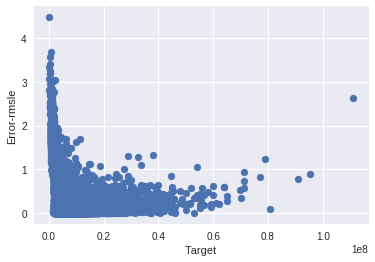

In [10]:
fig, ax = plt.subplots()
ax.scatter(error['target'],error['rmsle'])
ax.set_xlabel('Target')
ax.set_ylabel('Error-rmsle')
plt.show()

So how about the Ratio of the error versus the price (Low prices don't look so good in this model).  And we see the issue is apparent in both the RMSLE and RMSE.  Clearly, something is happening at low prices that our model is not handling well.

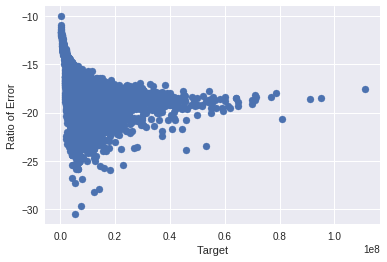

In [12]:
fig, ax = plt.subplots()
ax.scatter(y_train,np.log(error.rmsle/y_train))
ax.set_xlabel('Target')
ax.set_ylabel('Ratio of Error-RMSLE')
plt.show()

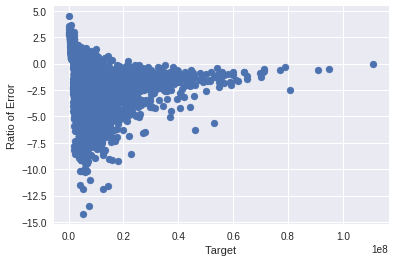

In [13]:
fig, ax = plt.subplots()
ax.scatter(y_train,np.log(error.rmse/y_train))
ax.set_xlabel('Target')
ax.set_ylabel('Ratio of Error-RMSE')
plt.show()